# 02 — Behavioural Analysis

The goal here is to understand who actually drives hospitality purchasing at SUFC. Specifically: is this a corporate or individual game? How concentrated is revenue? Do people come back, and is gifting/hosting a thing?

## Setup

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

# Visual style
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)
sns.set_theme(style='whitegrid', palette='muted')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 120

ticket_sales = pd.read_csv('../data/raw/ticket_sales.csv')
customers = pd.read_csv('../data/raw/customers.csv')

# Apply cleaning from Notebook 01
ticket_sales['event_date'] = pd.to_datetime(ticket_sales['event_date'], errors='coerce')
# same cleaning as NB01
customers['is_england_customer'] = customers['district'].notna()

print(f"Ticket sales: {len(ticket_sales):,} rows")

Ticket sales: 43,289 rows


In [7]:
# merge purchaser info onto tickets
df = ticket_sales.merge(
    customers,
    left_on='purchaser_id',
    right_on='customer_id',
    how='left',
    suffixes=('', '_purchaser')
)

# also get owner details for gifting analysis
owner_cols = ['customer_id', 'customer_type', 'age', 'gender']

df = df.merge(
    customers[owner_cols],
    left_on='owner_id',
    right_on='customer_id',
    how='left',
    suffixes=('', '_owner')
)

# Rename for clarity
df.rename(columns={
    'customer_type': 'purchaser_type',
    'customer_type_owner': 'owner_type',
    'age': 'purchaser_age',
    'age_owner': 'owner_age',
    'gender': 'purchaser_gender',
    'gender_owner': 'owner_gender'
}, inplace=True)

# Flag: is this a self-purchase (purchaser == owner)?
df['is_self_purchase'] = df['purchaser_id'] == df['owner_id']

## Foundation metrics

In [8]:
total_tickets = len(df)
total_transactions = df['transaction_id'].nunique()
unique_purchasers = df['purchaser_id'].nunique()
unique_owners = df['owner_id'].nunique()
unique_events = df['product_description'].nunique()

print(f'Total tickets:          {total_tickets:,}')
print(f'Unique transactions:    {total_transactions:,}')
print(f'Unique purchasers:      {unique_purchasers}')
print(f'Unique owners:          {unique_owners}')
print(f'Unique events:          {unique_events}')
print(f'\nAvg tickets per purchaser: {total_tickets / unique_purchasers:,.1f}')
print(f'Avg tickets per event:     {total_tickets / unique_events:,.1f}')

Total tickets:          43,289
Unique transactions:    43,289
Unique purchasers:      256
Unique owners:          276
Unique events:          54

Avg tickets per purchaser: 169.1
Avg tickets per event:     801.6


## Tickets per purchaser

How is volume distributed? If a few buyers dominate, that's a concentration risk.

In [9]:
tickets_per_purchaser = (
    df.groupby('purchaser_id')['transaction_id']
      .count()
      .reset_index(name='ticket_count')
      .sort_values('ticket_count', ascending=False)
      .reset_index(drop=True)
)

tickets_per_purchaser = tickets_per_purchaser.merge(
    customers[['customer_id', 'customer_type']],
    left_on='purchaser_id',
    right_on='customer_id',
    how='left'
).drop(columns='customer_id')

# Key stats
print(f"Mean:   {tickets_per_purchaser['ticket_count'].mean():,.1f}")
print(f"Median: {tickets_per_purchaser['ticket_count'].median():,.1f}")
print(f"Max:    {tickets_per_purchaser['ticket_count'].max():,}")
print(f"Min:    {tickets_per_purchaser['ticket_count'].min():,}")
print(f"Std:    {tickets_per_purchaser['ticket_count'].std():,.1f}")

# Top 5 share
top_5_tickets = tickets_per_purchaser.head(5)['ticket_count'].sum()
top_5_share = top_5_tickets / total_tickets * 100
print(f"\nTop 5 purchasers: {top_5_tickets:,} tickets ({top_5_share:.1f}% of total)")

# Top 10 share
top_10_tickets = tickets_per_purchaser.head(10)['ticket_count'].sum()
top_10_share = top_10_tickets / total_tickets * 100
print(f"Top 10 purchasers: {top_10_tickets:,} tickets ({top_10_share:.1f}% of total)")

# Top 20 share
top_20_tickets = tickets_per_purchaser.head(20)['ticket_count'].sum()

Mean:   169.1
Median: 46.0
Max:    4,402
Min:    1
Std:    422.1

Top 5 purchasers: 12,570 tickets (29.0% of total)
Top 10 purchasers: 18,193 tickets (42.0% of total)


In [10]:
top_10 = tickets_per_purchaser.head(10).copy()
top_10['rank'] = range(1, 11)
top_10['pct_of_total'] = (top_10['ticket_count'] / total_tickets * 100).round(1)
top_10['cumulative_pct'] = top_10['pct_of_total'].cumsum().round(1)

print('\nTop 10 purchasers')
print('-' * 40)
for _, row in top_10.iterrows():
    print(f"#{row['rank']:>2}  |  {row['customer_type']:<10}  |  {row['ticket_count']:>5,} tickets  |  {row['pct_of_total']:>5.1f}%  |  cum: {row['cumulative_pct']:>5.1f}%")


Top 10 purchasers
----------------------------------------
# 1  |  Account     |  4,402 tickets  |   10.2%  |  cum:  10.2%
# 2  |  Account     |  3,008 tickets  |    6.9%  |  cum:  17.1%
# 3  |  Account     |  1,740 tickets  |    4.0%  |  cum:  21.1%
# 4  |  Account     |  1,728 tickets  |    4.0%  |  cum:  25.1%
# 5  |  Account     |  1,692 tickets  |    3.9%  |  cum:  29.0%
# 6  |  Account     |  1,404 tickets  |    3.2%  |  cum:  32.2%
# 7  |  Account     |  1,220 tickets  |    2.8%  |  cum:  35.0%
# 8  |  Account     |  1,175 tickets  |    2.7%  |  cum:  37.7%
# 9  |  Account     |    960 tickets  |    2.2%  |  cum:  39.9%
#10  |  Account     |    864 tickets  |    2.0%  |  cum:  41.9%


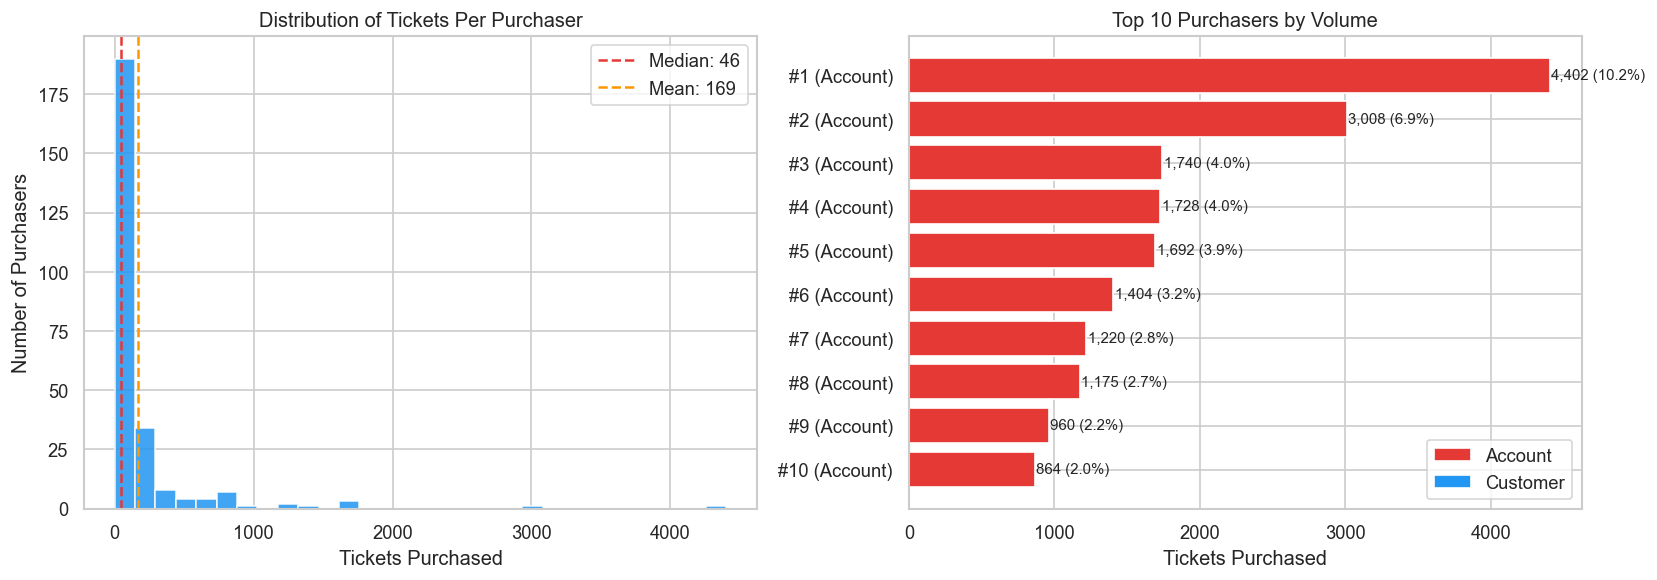

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(tickets_per_purchaser['ticket_count'], bins=30, color='#2196F3', edgecolor='white', alpha=0.85)
axes[0].axvline(tickets_per_purchaser['ticket_count'].median(), color='#E53935', linestyle='--', linewidth=1.5, label=f"Median: {tickets_per_purchaser['ticket_count'].median():.0f}")
axes[0].axvline(tickets_per_purchaser['ticket_count'].mean(), color='#FF9800', linestyle='--', linewidth=1.5, label=f"Mean: {tickets_per_purchaser['ticket_count'].mean():.0f}")
axes[0].set_xlabel('Tickets Purchased')
axes[0].set_ylabel('Number of Purchasers')
axes[0].set_title('Distribution of Tickets Per Purchaser')
axes[0].legend()

# top 10 bar chart
top_10_plot = top_10.sort_values('ticket_count', ascending=True)
colors = ['#E53935' if t == 'Account' else '#2196F3' for t in top_10_plot['customer_type']]
axes[1].barh(range(10), top_10_plot['ticket_count'], color=colors, edgecolor='white')
axes[1].set_yticks(range(10))
axes[1].set_yticklabels([f"#{r} ({t})" for r, t in zip(top_10_plot['rank'], top_10_plot['customer_type'])])
axes[1].set_xlabel('Tickets Purchased')
axes[1].set_title('Top 10 Purchasers by Volume')

# Add value labels
for i, (v, pct) in enumerate(zip(top_10_plot['ticket_count'], top_10_plot['pct_of_total'])):
    axes[1].text(v + 10, i, f'{v:,} ({pct}%)', va='center', fontsize=9)

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#E53935', label='Account'), Patch(facecolor='#2196F3', label='Customer')]
axes[1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.savefig('../data/charts/tickets_per_purchaser_distribution.png', bbox_inches='tight')
plt.show()

## Account vs individual split

Is this fundamentally a B2B corporate product or a B2C fan experience?

In [12]:
type_split = (
    df.groupby('purchaser_type')
      .agg(
          ticket_count=('transaction_id', 'count'),
          unique_purchasers=('purchaser_id', 'nunique'),
          unique_transactions=('transaction_id', 'nunique')
      )
      .reset_index()
)

type_split['pct_tickets'] = (type_split['ticket_count'] / total_tickets * 100).round(1)
type_split['avg_tickets_per_purchaser'] = (type_split['ticket_count'] / type_split['unique_purchasers']).round(1)
type_split['avg_transactions_per_purchaser'] = (type_split['unique_transactions'] / type_split['unique_purchasers']).round(1)

print('Account vs individual')
print('-' * 40)
for _, row in type_split.iterrows():
    print(f"\n{row['purchaser_type']}:")
    print(f"  Unique purchasers:           {row['unique_purchasers']}")
    print(f"  Tickets:                     {row['ticket_count']:,} ({row['pct_tickets']}%)")
    print(f"  Avg tickets per purchaser:   {row['avg_tickets_per_purchaser']:,.1f}")
    print(f"  Avg transactions per purchaser: {row['avg_transactions_per_purchaser']:.1f}")

Account vs individual
----------------------------------------

Account:
  Unique purchasers:           75
  Tickets:                     33,594 (77.6%)
  Avg tickets per purchaser:   447.9
  Avg transactions per purchaser: 447.9

Customer:
  Unique purchasers:           181
  Tickets:                     9,695 (22.4%)
  Avg tickets per purchaser:   53.6
  Avg transactions per purchaser: 53.6


In [32]:
# break down client_type (STH vs MBM) within each purchaser type
client_split = (
    df.groupby(['purchaser_type', 'client_type'])
      .size()
      .reset_index(name='tickets')
)
client_split['pct'] = (client_split['tickets'] / client_split.groupby('purchaser_type')['tickets'].transform('sum') * 100).round(1)

print('Client type breakdown within each purchaser type')
print('-' * 55)
for ptype in client_split['purchaser_type'].unique():
    print(f"\n{ptype}:")
    for _, row in client_split[client_split['purchaser_type'] == ptype].iterrows():
        print(f"  {row['client_type']}: {row['tickets']:,} tickets ({row['pct']}%)")

Client type breakdown within each purchaser type
-------------------------------------------------------

Account:
  Match by Match Ticket Holder: 5,680 tickets (16.9%)
  Season Ticket Holder: 27,914 tickets (83.1%)

Customer:
  Match by Match Ticket Holder: 4,793 tickets (49.4%)
  Season Ticket Holder: 4,902 tickets (50.6%)


In [13]:
tickets_by_type = (
    df.groupby(['purchaser_id', 'purchaser_type'])
      .size()
      .reset_index(name='ticket_count')
)

print('\nPer-purchaser distribution by type — DISTRIBUTION')
print('-' * 60)
for ptype in tickets_by_type['purchaser_type'].unique():
    subset = tickets_by_type[tickets_by_type['purchaser_type'] == ptype]['ticket_count']
    print(f"\n{ptype}:")
    print(f"  Count:  {len(subset)}")
    print(f"  Mean:   {subset.mean():,.1f}")
    print(f"  Median: {subset.median():,.1f}")
    print(f"  Max:    {subset.max():,}")
    print(f"  Min:    {subset.min():,}")


Per-purchaser distribution by type — DISTRIBUTION
------------------------------------------------------------

Account:
  Count:  75
  Mean:   447.9
  Median: 188.0
  Max:    4,402
  Min:    1

Customer:
  Count:  181
  Mean:   53.6
  Median: 24.0
  Max:    732
  Min:    1


C:\Users\USER\AppData\Local\Temp\ipykernel_22704\3539040073.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot([account_data, customer_data], labels=['Account', 'Customer'],


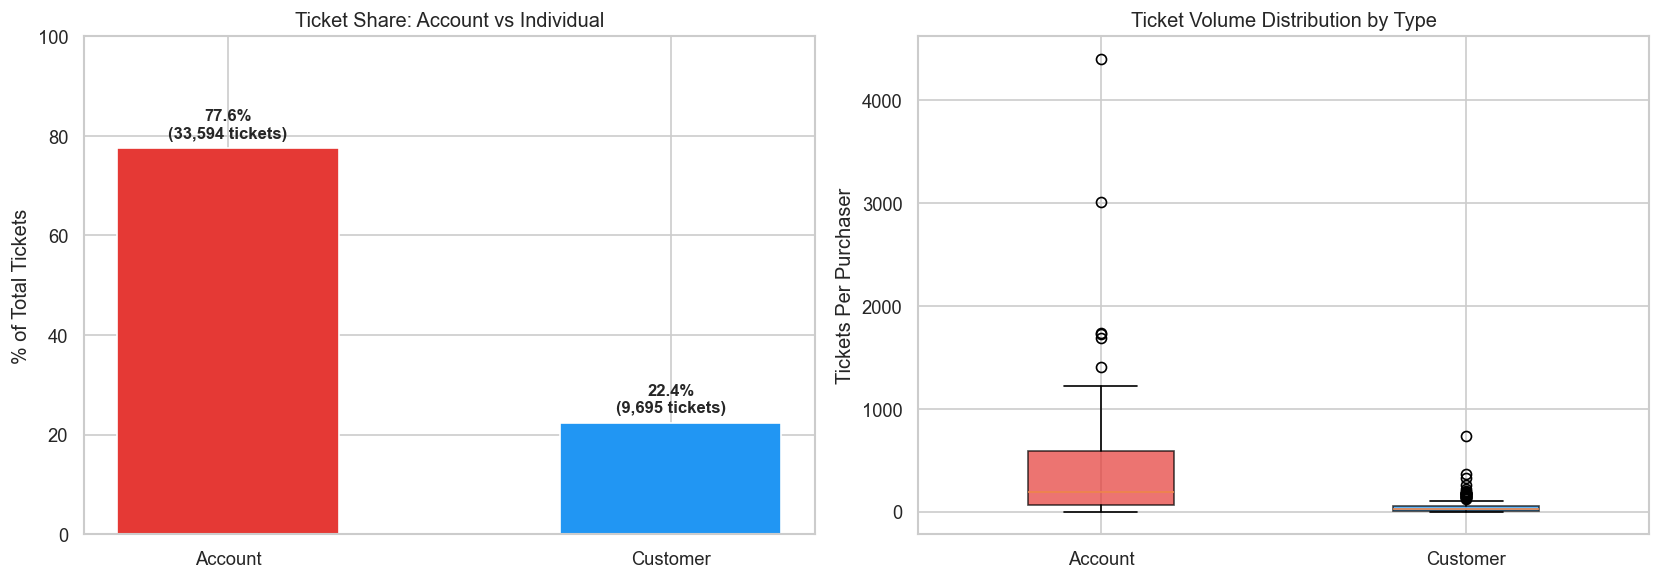

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

bars = axes[0].bar(type_split['purchaser_type'], type_split['pct_tickets'],
                   color=['#E53935', '#2196F3'], edgecolor='white', width=0.5)
axes[0].set_ylabel('% of Total Tickets')
axes[0].set_title('Ticket Share: Account vs Individual')
axes[0].set_ylim(0, 100)
for bar, pct, count in zip(bars, type_split['pct_tickets'], type_split['ticket_count']):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                f'{pct}%\n({count:,} tickets)', ha='center', fontsize=10, fontweight='bold')

# Box plot — tickets per purchaser by type
account_data = tickets_by_type[tickets_by_type['purchaser_type'] == 'Account']['ticket_count']
customer_data = tickets_by_type[tickets_by_type['purchaser_type'] == 'Customer']['ticket_count']
bp = axes[1].boxplot([account_data, customer_data], labels=['Account', 'Customer'],
                     patch_artist=True, widths=0.4)
bp['boxes'][0].set_facecolor('#E53935')
bp['boxes'][1].set_facecolor('#2196F3')
for box in bp['boxes']:
    box.set_alpha(0.7)
axes[1].set_ylabel('Tickets Per Purchaser')
axes[1].set_title('Ticket Volume Distribution by Type')

plt.tight_layout()
plt.savefig('../data/charts/account_vs_individual.png', bbox_inches='tight')
plt.show()

## Repeat purchase behaviour

High repeat rates = loyalty-driven revenue. Low = acquisition-dependent.

In [15]:
transactions_per_purchaser = (
    df.groupby('purchaser_id')
      .agg(
          transaction_count=('transaction_id', 'nunique'),
          event_count=('product_description', 'nunique'),
          ticket_count=('transaction_id', 'count')
      )
      .reset_index()
)

transactions_per_purchaser = transactions_per_purchaser.merge(
    customers[['customer_id', 'customer_type']],
    left_on='purchaser_id',
    right_on='customer_id',
    how='left'
).drop(columns='customer_id')

transactions_per_purchaser['is_repeat'] = transactions_per_purchaser['transaction_count'] > 1

repeat_count = transactions_per_purchaser['is_repeat'].sum()
one_time_count = (~transactions_per_purchaser['is_repeat']).sum()
repeat_rate = repeat_count / len(transactions_per_purchaser) * 100

print(f'Repeat purchasers (>1 transaction): {repeat_count} ({repeat_rate:.1f}%)')
print(f'One-time purchasers:                {one_time_count} ({100 - repeat_rate:.1f}%)')

repeat_tickets = transactions_per_purchaser[transactions_per_purchaser['is_repeat']]['ticket_count'].sum()
onetime_tickets = transactions_per_purchaser[~transactions_per_purchaser['is_repeat']]['ticket_count'].sum()
print(f'\nTickets from repeat purchasers:  {repeat_tickets:,} ({repeat_tickets/total_tickets*100:.1f}%)')
print(f'Tickets from one-time purchasers: {onetime_tickets:,} ({onetime_tickets/total_tickets*100:.1f}%)')

print(f'\nEvents per purchaser:')
print(f"  Mean:   {transactions_per_purchaser['event_count'].mean():.1f}")
print(f"  Median: {transactions_per_purchaser['event_count'].median():.1f}")
print(f"  Max:    {transactions_per_purchaser['event_count'].max()}")

Repeat purchasers (>1 transaction): 241 (94.1%)
One-time purchasers:                15 (5.9%)

Tickets from repeat purchasers:  43,274 (100.0%)
Tickets from one-time purchasers: 15 (0.0%)

Events per purchaser:
  Mean:   23.4
  Median: 23.0
  Max:    49


In [16]:
# by type
repeat_by_type = (
    transactions_per_purchaser
    .groupby('customer_type')
    .agg(
        total_purchasers=('purchaser_id', 'count'),
        repeat_purchasers=('is_repeat', 'sum'),
        avg_transactions=('transaction_count', 'mean'),
        avg_events=('event_count', 'mean')
    )
    .reset_index()
)
repeat_by_type['repeat_rate'] = (repeat_by_type['repeat_purchasers'] / repeat_by_type['total_purchasers'] * 100).round(1)

print('\nRepeat rate by type')
print('-' * 40)
for _, row in repeat_by_type.iterrows():
    print(f"\n{row['customer_type']}:")
    print(f"  Purchasers: {row['total_purchasers']:.0f}  |  Repeat: {row['repeat_purchasers']:.0f} ({row['repeat_rate']}%)")
    print(f"  Avg transactions: {row['avg_transactions']:.1f}  |  Avg events: {row['avg_events']:.1f}")


Repeat rate by type
----------------------------------------

Account:
  Purchasers: 75  |  Repeat: 73 (97.3%)
  Avg transactions: 447.9  |  Avg events: 30.5

Customer:
  Purchasers: 181  |  Repeat: 168 (92.8%)
  Avg transactions: 53.6  |  Avg events: 20.5


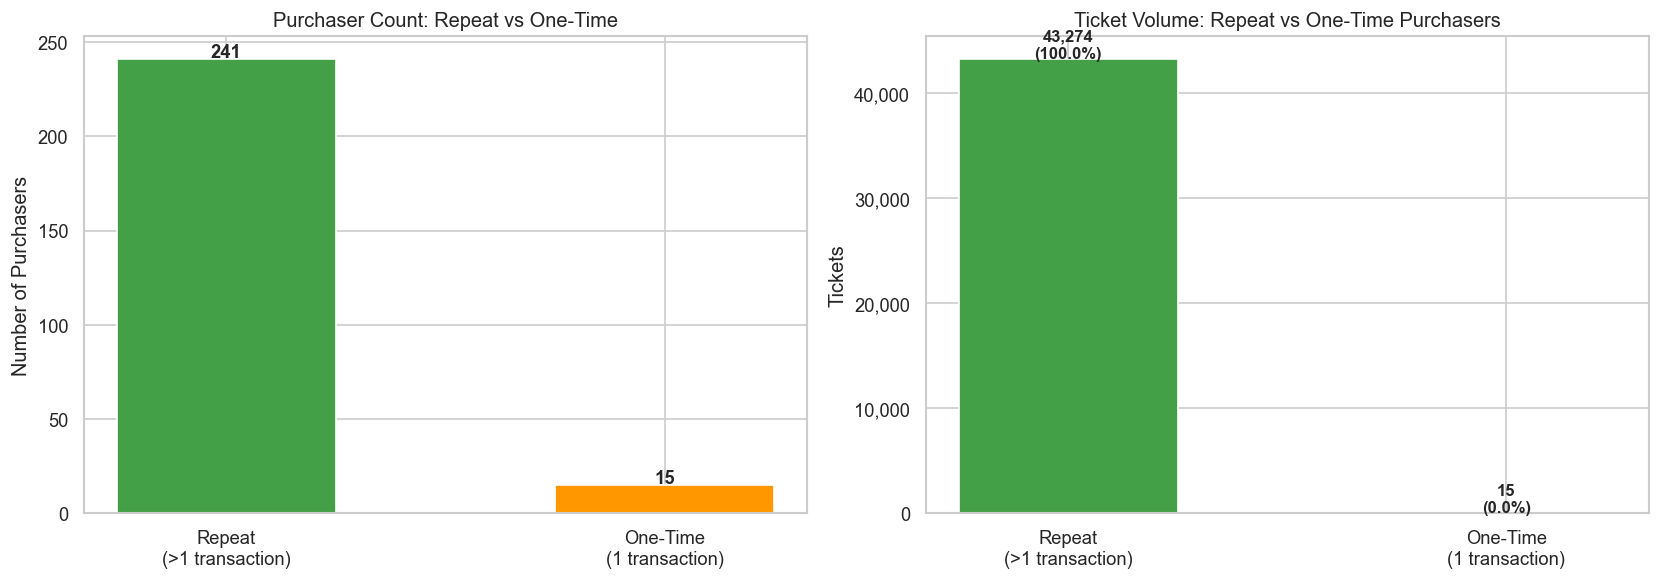

In [17]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

labels = ['Repeat\n(>1 transaction)', 'One-Time\n(1 transaction)']
counts = [repeat_count, one_time_count]
ticket_counts = [repeat_tickets, onetime_tickets]
bar_colors = ['#43A047', '#FF9800']

bars = axes[0].bar(labels, counts, color=bar_colors, edgecolor='white', width=0.5)
axes[0].set_ylabel('Number of Purchasers')
axes[0].set_title('Purchaser Count: Repeat vs One-Time')
for bar, c in zip(bars, counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{c}', ha='center', fontsize=11, fontweight='bold')

bars2 = axes[1].bar(labels, ticket_counts, color=bar_colors, edgecolor='white', width=0.5)
axes[1].set_ylabel('Tickets')
axes[1].set_title('Ticket Volume: Repeat vs One-Time Purchasers')
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
for bar, tc in zip(bars2, ticket_counts):
    pct = tc / total_tickets * 100
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100,
                f'{tc:,}\n({pct:.1f}%)', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/charts/repeat_vs_onetime.png', bbox_inches='tight')
plt.show()

## Purchaser vs owner (gifting/hosting)

When purchaser ≠ owner, that's either gifting or corporate hosting. Worth checking how common this is and whether it breaks down differently for Accounts vs Customers.

In [18]:
self_purchase_count = df['is_self_purchase'].sum()
gifted_count = (~df['is_self_purchase']).sum()
self_purchase_rate = self_purchase_count / total_tickets * 100
gifted_rate = gifted_count / total_tickets * 100

print(f'Self-purchase (purchaser = owner):  {self_purchase_count:,} ({self_purchase_rate:.1f}%)')
print(f'Gifted/hosted (purchaser ≠ owner):  {gifted_count:,} ({gifted_rate:.1f}%)')

Self-purchase (purchaser = owner):  42,142 (97.4%)
Gifted/hosted (purchaser ≠ owner):  1,147 (2.6%)


In [19]:
gifting_by_type = (
    df.groupby('purchaser_type')
      .agg(
          total_tickets=('transaction_id', 'count'),
          self_purchase=('is_self_purchase', 'sum')
      )
      .reset_index()
)
gifting_by_type['gifted'] = gifting_by_type['total_tickets'] - gifting_by_type['self_purchase']
gifting_by_type['gifted_rate'] = (gifting_by_type['gifted'] / gifting_by_type['total_tickets'] * 100).round(1)
gifting_by_type['self_rate'] = (gifting_by_type['self_purchase'] / gifting_by_type['total_tickets'] * 100).round(1)

print('\nGifting by purchaser type')
print('-' * 40)
for _, row in gifting_by_type.iterrows():
    print(f"\n{row['purchaser_type']}:")
    print(f"  Total tickets:    {row['total_tickets']:,}")
    print(f"  Self-purchase:    {row['self_purchase']:,.0f} ({row['self_rate']}%)")
    print(f"  Gifted/hosted:    {row['gifted']:,.0f} ({row['gifted_rate']}%)")


Gifting by purchaser type
----------------------------------------

Account:
  Total tickets:    33,594
  Self-purchase:    33,594 (100.0%)
  Gifted/hosted:    0 (0.0%)

Customer:
  Total tickets:    9,695
  Self-purchase:    8,548 (88.2%)
  Gifted/hosted:    1,147 (11.8%)


In [20]:
# who receives gifted tickets?
gifted_tickets = df[~df['is_self_purchase']].copy()

gifted_cross = (
    gifted_tickets.groupby(['purchaser_type', 'owner_type'])
    .size()
    .reset_index(name='ticket_count')
)
gifted_cross['pct'] = (gifted_cross['ticket_count'] / gifted_count * 100).round(1)

print('\nGifted flow: purchaser type -> owner type')
print('-' * 40)
for _, row in gifted_cross.iterrows():
    print(f"  {row['purchaser_type']} -> {row['owner_type']}:  {row['ticket_count']:,} tickets ({row['pct']}%)")


Gifted flow: purchaser type -> owner type
----------------------------------------
  Customer -> Account:  368 tickets (32.1%)
  Customer -> Customer:  779 tickets (67.9%)


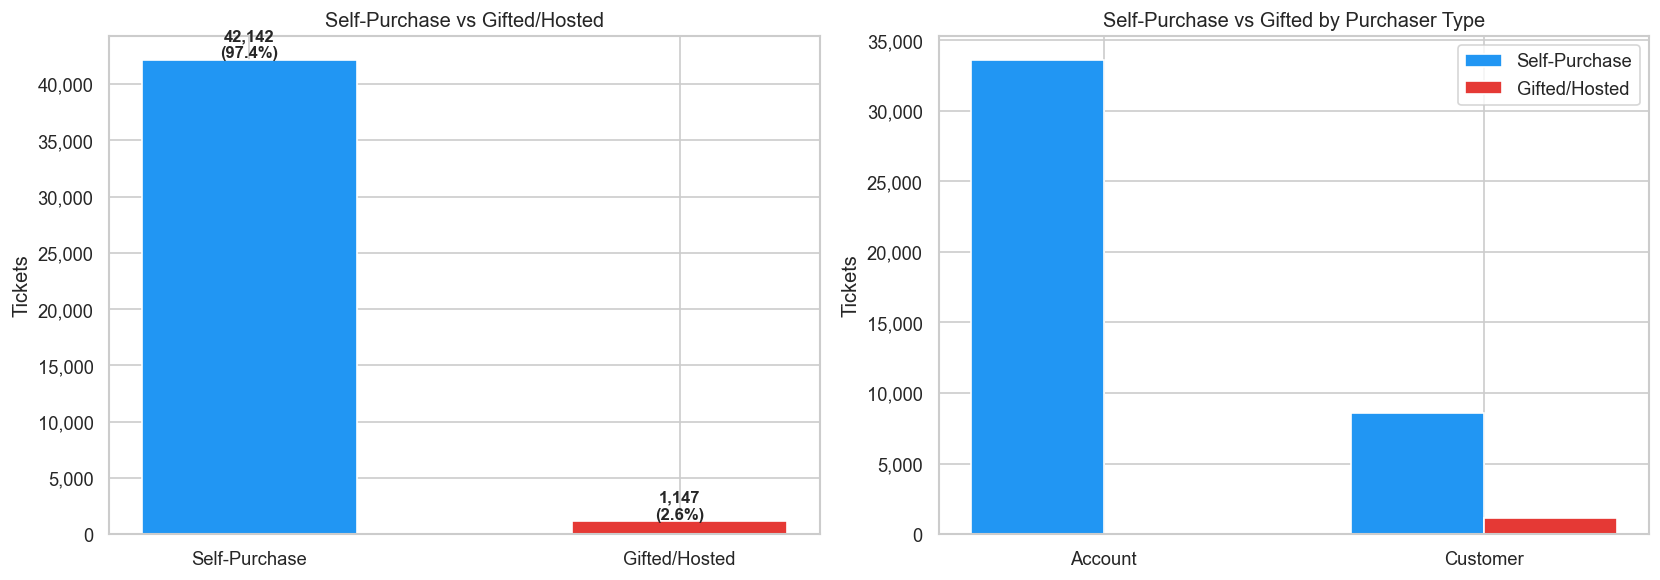

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

labels_po = ['Self-Purchase', 'Gifted/Hosted']
sizes_po = [self_purchase_count, gifted_count]
colors_po = ['#2196F3', '#E53935']

bars_po = axes[0].bar(labels_po, sizes_po, color=colors_po, edgecolor='white', width=0.5)
axes[0].set_ylabel('Tickets')
axes[0].set_title('Self-Purchase vs Gifted/Hosted')
axes[0].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))
for bar, s, r in zip(bars_po, sizes_po, [self_purchase_rate, gifted_rate]):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 200,
                f'{s:,}\n({r:.1f}%)', ha='center', fontsize=10, fontweight='bold')

# by type
x_labels = gifting_by_type['purchaser_type']
x_pos = range(len(x_labels))
width = 0.35
axes[1].bar([p - width/2 for p in x_pos], gifting_by_type['self_purchase'],
            width, label='Self-Purchase', color='#2196F3', edgecolor='white')
axes[1].bar([p + width/2 for p in x_pos], gifting_by_type['gifted'],
            width, label='Gifted/Hosted', color='#E53935', edgecolor='white')
axes[1].set_xticks(x_pos)
axes[1].set_xticklabels(x_labels)
axes[1].set_ylabel('Tickets')
axes[1].set_title('Self-Purchase vs Gifted by Purchaser Type')
axes[1].legend()
axes[1].yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: f'{x:,.0f}'))

plt.tight_layout()
plt.savefig('../data/charts/purchaser_vs_owner.png', bbox_inches='tight')
plt.show()

## Season comparison

Checking whether the corporate reliance is stable, growing, or shifting across seasons.

In [22]:
# derive season from event_date (football seasons run Aug-May)
df['event_year'] = df['event_date'].dt.year
df['event_month'] = df['event_date'].dt.month

df['season'] = df['event_date'].apply(
    lambda x: f"{x.year}/{x.year+1}" if x.month >= 7 else f"{x.year-1}/{x.year}"
)

print('Tickets by season')
print('-' * 40)
season_counts = df['season'].value_counts().sort_index()
for season, count in season_counts.items():
    print(f"  {season}: {count:,} tickets")

Tickets by season
----------------------------------------
  2023/2024: 223 tickets
  2024/2025: 23,355 tickets
  2025/2026: 19,711 tickets


In [23]:
# compare key metrics across seasons
season_metrics = []

for season in sorted(df['season'].unique()):
    s_df = df[df['season'] == season]
    s_total = len(s_df)
    s_purchasers = s_df['purchaser_id'].nunique()
    
    s_account_tickets = len(s_df[s_df['purchaser_type'] == 'Account'])
    s_account_pct = s_account_tickets / s_total * 100
    
    s_txn_per_purch = s_df.groupby('purchaser_id')['transaction_id'].nunique()
    s_repeat_rate = (s_txn_per_purch > 1).mean() * 100
    
    s_gifted_rate = (~s_df['is_self_purchase']).mean() * 100
    
    s_tickets_per_purch = s_df.groupby('purchaser_id').size().sort_values(ascending=False)
    s_top10_share = s_tickets_per_purch.head(10).sum() / s_total * 100
    
    season_metrics.append({
        'Season': season,
        'Tickets': s_total,
        'Purchasers': s_purchasers,
        'Avg Tickets/Purchaser': round(s_total / s_purchasers, 1),
        'Account %': round(s_account_pct, 1),
        'Repeat Rate %': round(s_repeat_rate, 1),
        'Gifted Rate %': round(s_gifted_rate, 1),
        'Top 10 Concentration %': round(s_top10_share, 1)
    })

season_df = pd.DataFrame(season_metrics)
display(season_df.set_index('Season').T)

Season,2023/2024,2024/2025,2025/2026
Tickets,223.0,23355.0,19711.0
Purchasers,1.0,204.0,155.0
Avg Tickets/Purchaser,223.0,114.5,127.2
Account %,0.0,80.0,75.6
Repeat Rate %,100.0,95.1,96.1
Gifted Rate %,0.0,1.8,3.7
Top 10 Concentration %,100.0,43.3,44.4


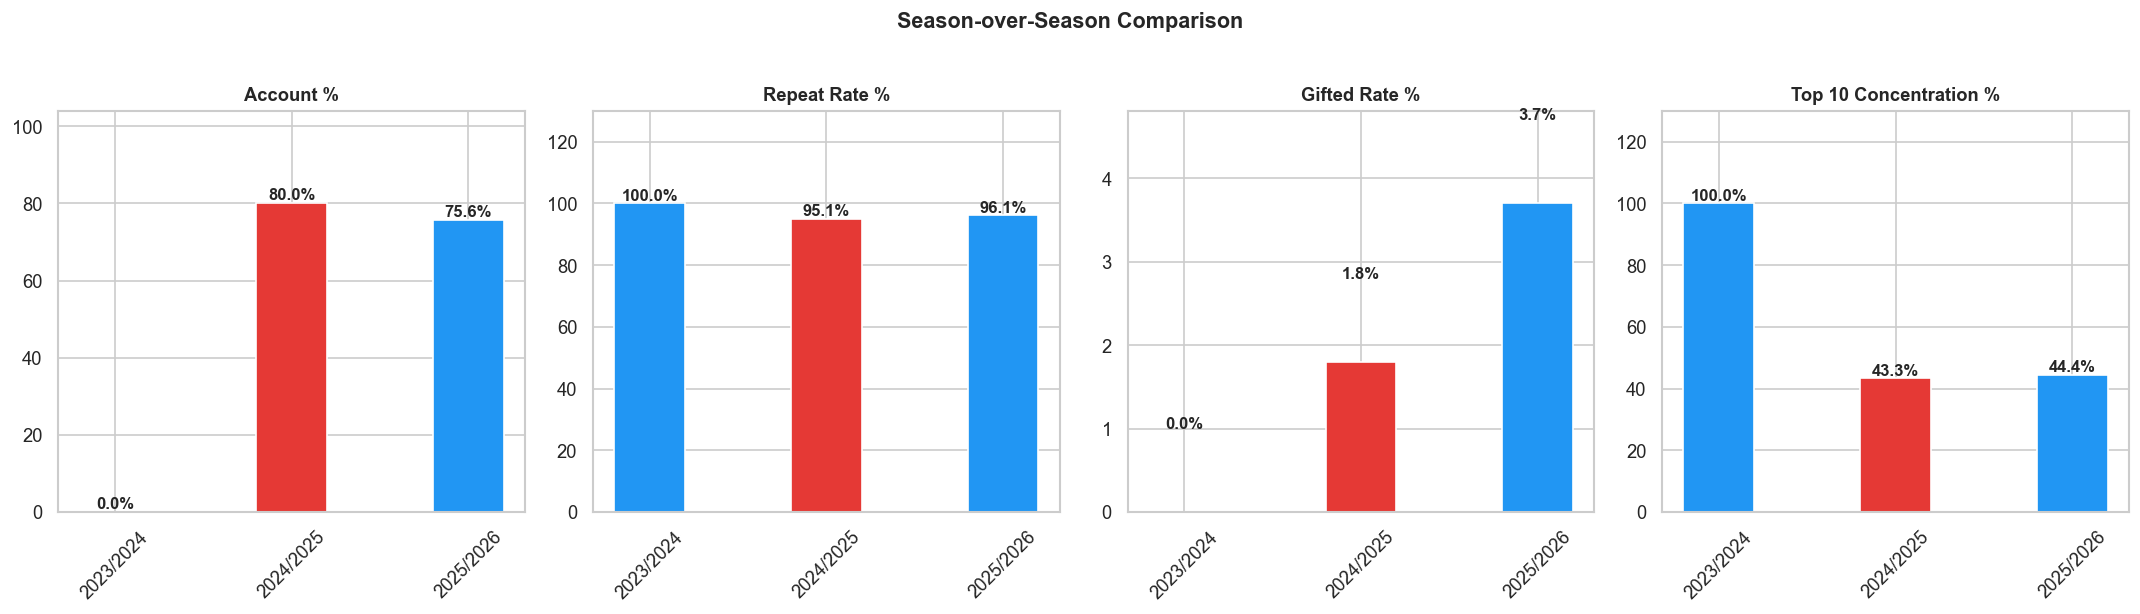

In [24]:
metrics_to_plot = ['Account %', 'Repeat Rate %', 'Gifted Rate %', 'Top 10 Concentration %']

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(18, 5))
colors_season = ['#2196F3', '#E53935']

for ax, metric in zip(axes, metrics_to_plot):
    bars = ax.bar(season_df['Season'], season_df[metric],
                  color=colors_season[:len(season_df)], edgecolor='white', width=0.4)
    ax.set_title(metric, fontsize=11, fontweight='bold')
    ax.set_ylim(0, max(season_df[metric]) * 1.3)
    for bar, val in zip(bars, season_df[metric]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
                f'{val:.1f}%', ha='center', fontsize=10, fontweight='bold')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Season-over-Season Comparison', fontsize=13, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../data/charts/season_comparison.png', bbox_inches='tight')
plt.show()

## Revenue concentration (Lorenz/Gini)

In [25]:
sorted_purchasers = tickets_per_purchaser.sort_values('ticket_count', ascending=False).reset_index(drop=True)
sorted_purchasers['cumulative_tickets'] = sorted_purchasers['ticket_count'].cumsum()
sorted_purchasers['cumulative_pct'] = (sorted_purchasers['cumulative_tickets'] / total_tickets * 100).round(2)
sorted_purchasers['purchaser_pct'] = ((sorted_purchasers.index + 1) / len(sorted_purchasers) * 100).round(2)

print('Concentration thresholds')
print('-' * 40)

for threshold in [5, 10, 20, 50]:
    n = max(1, int(len(sorted_purchasers) * threshold / 100))
    pct_tickets = sorted_purchasers.head(n)['ticket_count'].sum() / total_tickets * 100
    print(f"Top {threshold}% ({n} buyers) -> {pct_tickets:.1f}% of tickets")

# gini coefficient
ticket_counts_array = sorted_purchasers['ticket_count'].values
n = len(ticket_counts_array)
sorted_values = np.sort(ticket_counts_array)
cumulative = np.cumsum(sorted_values)
gini = (2 * np.sum((np.arange(1, n+1) * sorted_values)) - (n + 1) * np.sum(sorted_values)) / (n * np.sum(sorted_values))

print(f"\nGini: {gini:.3f} (0=equal, 1=concentrated)")
if gini > 0.6:
    print(f"  High concentration — heavy dependency on top purchasers")

Concentration thresholds
----------------------------------------
Top 5% (12 buyers) -> 45.5% of tickets
Top 10% (25 buyers) -> 64.2% of tickets
Top 20% (51 buyers) -> 78.9% of tickets
Top 50% (128 buyers) -> 95.6% of tickets

Gini: 0.761 (0=equal, 1=concentrated)
  High concentration — heavy dependency on top purchasers


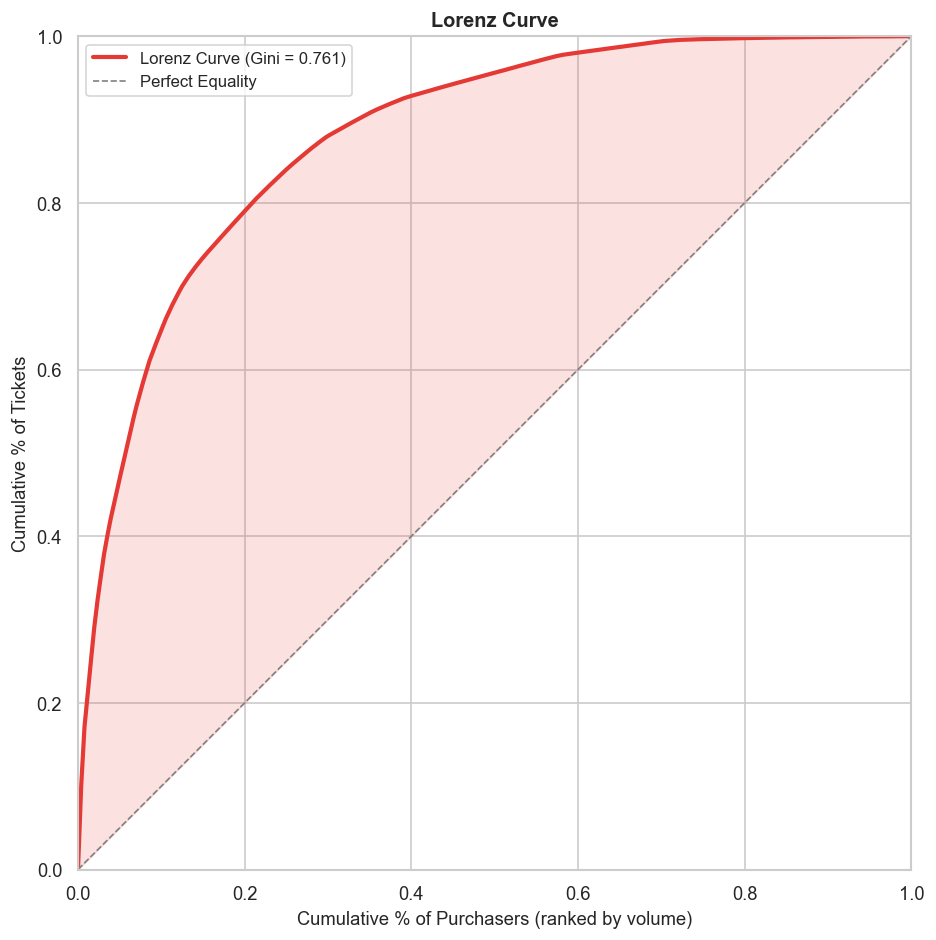

In [26]:
fig, ax = plt.subplots(figsize=(8, 8))

lorenz_x = sorted_purchasers['purchaser_pct'].values / 100
lorenz_y = sorted_purchasers['cumulative_pct'].values / 100
lorenz_x = np.insert(lorenz_x, 0, 0)
lorenz_y = np.insert(lorenz_y, 0, 0)

ax.plot(lorenz_x, lorenz_y, color='#E53935', linewidth=2.5, label=f'Lorenz Curve (Gini = {gini:.3f})')
ax.plot([0, 1], [0, 1], color='grey', linestyle='--', linewidth=1, label='Perfect Equality')
ax.fill_between(lorenz_x, lorenz_y, lorenz_x, alpha=0.15, color='#E53935')

ax.set_xlabel('Cumulative % of Purchasers (ranked by volume)', fontsize=11)
ax.set_ylabel('Cumulative % of Tickets', fontsize=11)
ax.set_title('Lorenz Curve', fontsize=12, fontweight='bold')
ax.legend(fontsize=10)
ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_aspect('equal')

plt.tight_layout()
plt.savefig('../data/charts/lorenz_curve.png', bbox_inches='tight')
plt.show()

## Summary

In [27]:
account_pct = type_split[type_split['purchaser_type'] == 'Account']['pct_tickets'].values
account_pct_val = account_pct[0] if len(account_pct) > 0 else 0

print(f'''Behavioural summary
{"-" * 40}

Concentration: Top 10 = {top_10_share:.1f}% of tickets, Gini = {gini:.3f}
Corporate share: Accounts = {account_pct_val:.1f}% of volume
Repeat rate: {repeat_rate:.1f}% of purchasers, driving {repeat_tickets/total_tickets*100:.1f}% of tickets
Gifting: {gifted_rate:.1f}% of tickets have purchaser != owner

The story: high-concentration, corporate-led, loyalty-driven hospitality product.
Key risk is dependency on a small number of corporate accounts.
Growth opportunity is in the individual customer segment.''')

Behavioural summary
----------------------------------------

Concentration: Top 10 = 42.0% of tickets, Gini = 0.761
Corporate share: Accounts = 77.6% of volume
Repeat rate: 94.1% of purchasers, driving 100.0% of tickets
Gifting: 2.6% of tickets have purchaser != owner

The story: high-concentration, corporate-led, loyalty-driven hospitality product.
Key risk is dependency on a small number of corporate accounts.
Growth opportunity is in the individual customer segment.


## Behavioural clustering (KMeans)

Clustering all 256 purchasers on purely transactional features — no demographics needed. Using log-transformed ticket count, transaction count, area diversity, and events attended. Standardised, then KMeans with k=4 (validated via elbow plot).

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# build purchaser-level features for clustering
purch_features = df.groupby('purchaser_id').agg(
    ticket_count=('transaction_id', 'count'),
    transaction_count=('transaction_id', 'nunique'),
    unique_areas=('area', 'nunique'),
    unique_events=('event_date', 'nunique'),
    purchaser_type=('purchaser_type', 'first')
).reset_index()

purch_features['log_tickets'] = np.log1p(purch_features['ticket_count'])

feature_cols = ['log_tickets', 'transaction_count', 'unique_areas', 'unique_events']
X = purch_features[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'Purchasers: {len(purch_features):,}')
print(f'Features: {feature_cols}')

Purchasers: 256
Features: ['log_tickets', 'transaction_count', 'unique_areas', 'unique_events']


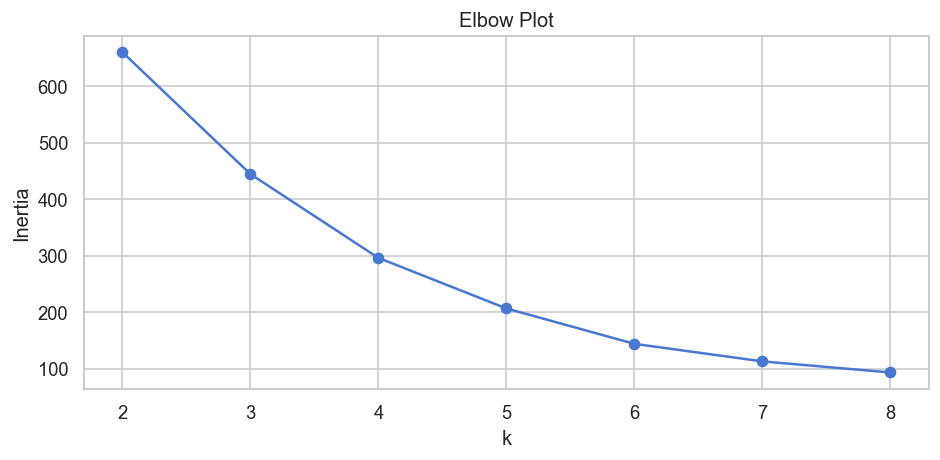

k=4 looks reasonable — diminishing returns after that.


In [29]:
# elbow plot to pick k
inertias = []
K_range = range(2, 9)
for k in K_range:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(list(K_range), inertias, 'o-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Plot')
plt.tight_layout()
plt.savefig('../data/charts/nb02_elbow_plot.png', bbox_inches='tight')
plt.show()
print('k=4 looks reasonable — diminishing returns after that.')

In [30]:
km4 = KMeans(n_clusters=4, n_init=10, random_state=42)
purch_features['cluster'] = km4.fit_predict(X_scaled)

cluster_profile = (
    purch_features.groupby('cluster')
    .agg(
        n_purchasers=('purchaser_id', 'count'),
        avg_tickets=('ticket_count', 'mean'),
        avg_transactions=('transaction_count', 'mean'),
        avg_areas=('unique_areas', 'mean'),
        avg_events=('unique_events', 'mean'),
        pct_accounts=('purchaser_type', lambda x: (x == 'Account').mean() * 100)
    )
    .round(1)
    .reset_index()
)
cluster_profile['pct_of_purchasers'] = (cluster_profile['n_purchasers'] / cluster_profile['n_purchasers'].sum() * 100).round(1)

ticket_share = purch_features.groupby('cluster')['ticket_count'].sum()
cluster_profile['pct_of_tickets'] = (ticket_share.values / ticket_share.sum() * 100).round(1)

print('Cluster profiles')
print('-' * 40)
display(cluster_profile)

Cluster profiles
----------------------------------------


,cluster,n_purchasers,avg_tickets,avg_transactions,avg_areas,avg_events,pct_accounts,pct_of_purchasers,pct_of_tickets
0,0,154,158.5,158.5,1.0,33.4,32.5,60.2,56.4
1,1,80,5.9,5.9,1.0,1.5,13.8,31.2,1.1
2,2,8,2046.1,2046.1,1.4,46.1,100.0,3.1,37.8
3,3,14,145.8,145.8,2.1,26.4,42.9,5.5,4.7


,segment_label,purchasers,total_tickets,avg_tickets,avg_events,pct_accounts,ticket_share_pct
0,Anchor Buyers (high-volume repeat),8,16369,2046.1,46.1,100.0,37.8
1,Core Regulars (mid-volume steady),154,24407,158.5,33.4,32.5,56.4
2,Occasional Buyers (low-volume repeat),14,2041,145.8,26.4,42.9,4.7
3,Light Touch (minimal engagement),80,472,5.9,1.5,13.8,1.1


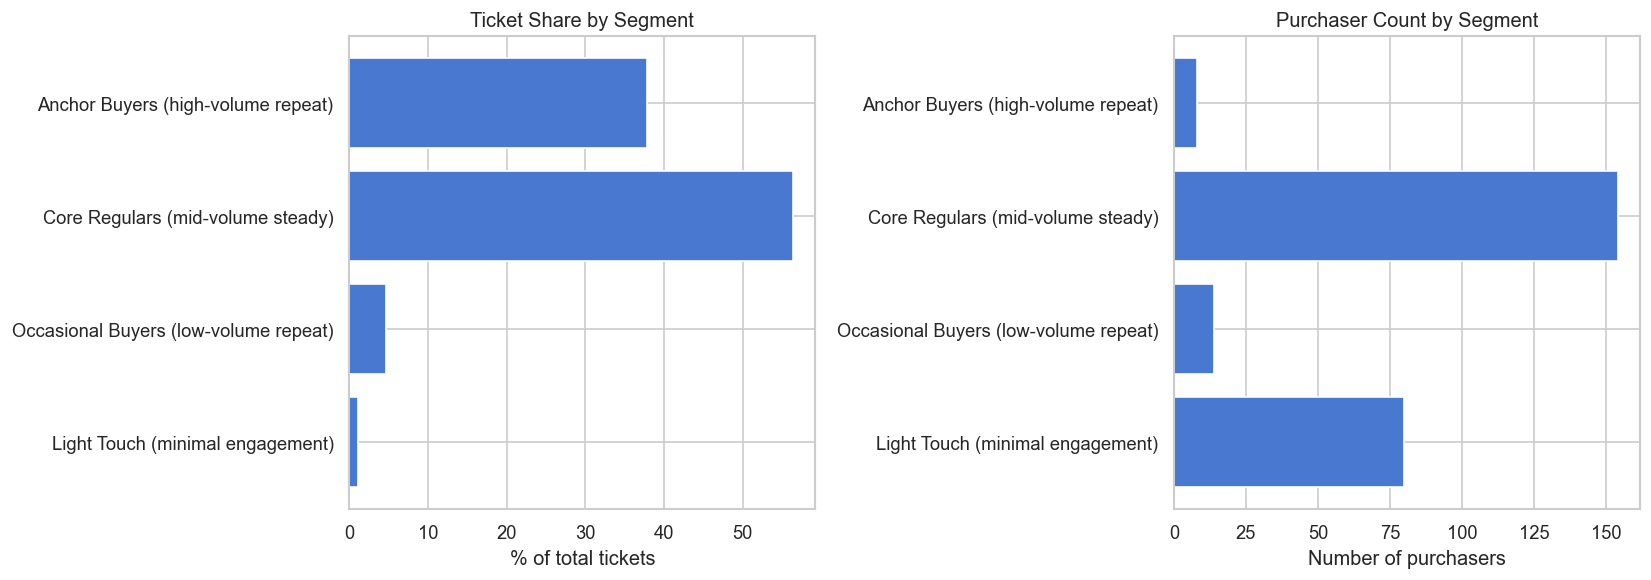

In [31]:
# label clusters by volume for interpretability
label_order = cluster_profile.sort_values('avg_tickets', ascending=False)['cluster'].tolist()
label_names = [
    'Anchor Buyers (high-volume repeat)',
    'Core Regulars (mid-volume steady)',
    'Occasional Buyers (low-volume repeat)',
    'Light Touch (minimal engagement)'
]
label_map = dict(zip(label_order, label_names))
purch_features['segment_label'] = purch_features['cluster'].map(label_map)

seg_summary = (
    purch_features.groupby('segment_label')
    .agg(
        purchasers=('purchaser_id', 'count'),
        total_tickets=('ticket_count', 'sum'),
        avg_tickets=('ticket_count', 'mean'),
        avg_events=('unique_events', 'mean'),
        pct_accounts=('purchaser_type', lambda x: (x == 'Account').mean() * 100)
    )
    .round(1)
    .sort_values('avg_tickets', ascending=False)
    .reset_index()
)
seg_summary['ticket_share_pct'] = (seg_summary['total_tickets'] / seg_summary['total_tickets'].sum() * 100).round(1)

display(seg_summary)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(seg_summary['segment_label'], seg_summary['ticket_share_pct'])
axes[0].set_xlabel('% of total tickets')
axes[0].set_title('Ticket Share by Segment')
axes[0].invert_yaxis()

axes[1].barh(seg_summary['segment_label'], seg_summary['purchasers'])
axes[1].set_xlabel('Number of purchasers')
axes[1].set_title('Purchaser Count by Segment')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../data/charts/nb02_behavioural_segments.png', bbox_inches='tight')
plt.show()

### What comes next

The demographic profiles of these segments (age, location, gender) are explored in Notebook 03. The behavioural picture here gives us the "what" — demographics will add the "who."